<a href="https://colab.research.google.com/github/jecampagne/cours_mallat_cdf/blob/main/cours2024/Ising2D_Metropolis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation simple d'un modèle d'Ising 2D

Dans ce notebook, on effectue une simulation simple qui ne prétend pas rivaliser avec les algorithmes sotwares ainsi que les implémentations hardwares les plus performants.  En 2min sur un CPU on peut obtenir une courbe de l'aimentation en fonction de la temperature qui montre une transition de phase assez proche de la théorie.

$$
\Large E = -J \sum_{(mn)}\sigma_m \sigma_n
$$


dont $(m,n)$ signifie des spins plus proches voisins dans une grille $NxN$ avec des conditions cycliques aux bords. La contribution de  4 paires centrées sur le spin $\sigma_{i,j}$  ($i,j:0,\dots,N-1$):

$$
\Large \Delta E = -J \sigma_{i,j} (\sigma_{i-1,j}+\sigma_{i+1,j}+\sigma_{i,j-1},\sigma_{i,j+1})
$$

On prend par la suite $J=k_B=1$. Par défaut, le modèle d'Ising utilise des spins $(+1;-1)$.

La méthode de génération d'une grille de spins à l'équilibre en fonction de la température peut se faire selon la méthode suivante:

1.   Choix d'une température $T$, et  initialisaton d'un réseau NxN avec par exemple tous les spins égaux à +1;
2.   On boucle sur $nloops$:

  *   tirage au sort d'un spin $(i,j)$ au hasard dans le réseau
  *   calcul de $\Delta E$
      *  si $\Delta E <= 0$ on change le signe du spin $\sigma_{i,j} = - \sigma_{ij}$
      *  si $\Delta E > 0$ alors le facteur de Boltzmann $p_B = e^{-\beta \Delta E}$  ($\beta = 1/T$) est comparé à $u \sim \mathcal{U}(0,1)$, c'est-à-dire un nombre tiré uniformément dans l'intervalle $[0,1]$:
        * si $u< p_B$ alors on accepte le renversement du spin  $\sigma_{i,j} = - \sigma_{ij}$, sinon le spin reste inchangé.
      * option: on peut calculer par exemple l'aimantation moyenne par spin à cette étape
3. A la fin, on obtient l'état du réseau et on peut calculer l'aimantation moyenne par spin.

Il s'agit de la méthod de Métropolis de génération d'une chaine de Markov qui doit donner au final un échantillon "c" ("c" pour configuration du réseau de spins) de la probabilité de Gibbs

$$
\Large p(c) = Z^{-1} e^{-\beta E_c}
$$

où $Z$ est le facteur de normalisation $Z=\sum_c e^{-\beta E_c}$. Notez que si on avait à calculer cette constante explicitement il faudrait scanner $2^{N^2}$ même si on peut user de symétrie ça fait beaucoup! $10^{308}$ pour une grille modeste où $N=32$.

Maintenant, on peut faire remarquer

   1. les valeurs de $\Delta E$ sont dénombrables, elles dépendent uniquement du nombre $n$ de spins voisins qui sont de sens opposé au spin $\sigma_{i,j}$:

|&nbsp;&nbsp;&nbsp; n &nbsp;&nbsp;&nbsp; |&nbsp;&nbsp;&nbsp; $\Delta E$ &nbsp;&nbsp;&nbsp;|
    | :---: | :---:|
    | 0|  8 |
    | 1| 4  |
    | 2| 0 |
    | 3| -4 |
    | 4| -8 |

Dans les cas $n=(2,3,4)$, le renversement du spin est accepté de facto car le facteur de Boltzmann est $>= 1$, et pour les 2 cas restant on peut calculer une fois pour toute  $p_1=e^{-4/T}$ et $p_2=e^{-8/T}$

  2. et stocker un spin $\{-1,+1\}$ sur un entier signé de nb-bits (eg. nb=8, 16, 32, 64) n'est pas des plus économique.


En fait on peut définir des opérations sur des spins binaires ($\{0,1\}$) éléments d'entiers non-signés par exemple de 32-bits. On alors la possibilité de générer en parallèlle 32 chaines de Markov. Le renversement du spin $\sigma_{i,i}$ est donné en 1 seule opération de bits:

$$
\Large \sigma_{i,j}=[(\sigma_{i,j}\wedge \sigma_{i-1,j}+\sigma_{i,j}\wedge \sigma_{i+1,j}+\sigma_{i,j}\wedge \sigma_{i,j-1}+\sigma_{i,j}\wedge \sigma_{i,j+1}+(R < p_1) + (R < p_2))\geq 2]\wedge \sigma_{ij}
$$

avec l'operateur  XOR noté "$∧$", $R$ un nombre aléatoire.


C'est une implémentation similaire qui est proposée avec du code JAX.



Pour aller plus loin lire :  https://arxiv.org/pdf/cond-mat/9703179.pdf









In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import jax.numpy as jnp
import jax
from functools import partial


@jax.jit
def temperature(T):
  # facteurs des probabilites
  beta = 1.0/T
  p0 = jnp.exp(-8.0*beta)
  p1 = (jnp.exp(-4.0*beta)-p0)/(1.0-p0)
  return 2.0*jnp.array([p0,p1]) # deuxp0 = p0*2.0; deuxp1 = p1*2.0

@jax.jit
def valid_index(i,N):
  # index avec conditions aux limites circulaires
  ii = jnp.where(i>=N,0,i)
  ii = jnp.where(ii<0,N-1,ii)
  return ii

@jax.jit
def spin_value(spin,i,j):
  # valeur du spin (i,j)
  N= spin.shape[0]
  ii = valid_index(i,N)
  jj = valid_index(j,N)
  return spin[jj][ii]

@jax.jit
def metropolis(key,spin,probas): # care change key at each call
  # 1-step metropolis:
  # flip d'un spin aleatoire selon la difference d'energie
  # entre etat initial et final
  N= spin.shape[0]
  spin_dtype = spin.dtype

  key, key1,key2= jax.random.split(key,num=3)
  i = jax.random.randint(key1,shape=(),minval=0,maxval=N)
  j = jax.random.randint(key2,shape=(),minval=0,maxval=N)
  s = spin[j][i]
  a1 = s^spin_value(spin,i-1,j)
  a2 = s^spin_value(spin,i+1,j)
  a3 = s^spin_value(spin,i,j-1)
  a4 = s^spin_value(spin,i,j+1)
  R1 = a1|a2|a3|a4
  R2 = ((a1|a2)&(a3|a4))|((a1&a2)|(a3&a4))

  key, key1,key2,key3,key4 = jax.random.split(key,num=5)
  deuxp0, deuxp1 =  probas

  u0 = jax.random.uniform(key1,(1,))
  r0 = jax.lax.select(u0 < deuxp0,
                 jax.random.bits(key2,shape=u0.shape,dtype=spin_dtype),
                 jnp.zeros(shape=u0.shape,dtype=spin_dtype)).squeeze()

  u1 = jax.random.uniform(key3,(1,))
  r1 = jax.lax.select(u1 < deuxp1,
                 jax.random.bits(key4,shape=u1.shape,dtype=spin_dtype),
                 jnp.zeros(shape=u1.shape,dtype=spin_dtype)).squeeze()

  res = s^(R2|(R1&r1)|r0)

  return spin.at[j,i].set(res)  # this a new array

@jax.jit
def couche(spin,b):
  # extraction de la realisation "b" parmi les bits de chaque spin
  N = spin.shape[0]
  spin_dtype = spin.dtype
  two = jnp.array([2],dtype=spin_dtype)
  mask = jnp.ones((N,N),dtype=spin_dtype)*two**b
  res = jnp.clip(jnp.bitwise_and(spin,mask),a_min=0,a_max=1) # spin in [0,1]
  return -1.0*jnp.where(res==0,-1.0,res)  # spin 0=>-1 and then flip all spins

vcouche = jax.jit(jax.vmap(couche,in_axes=(None,0)))


@jax.jit
def aimant_stat(spin):
  # calcul de l'aimantation moyenne sur l'ensemble des realisations de spin
  N= spin.shape[0]
  nbits = spin[0,0].nbytes * 8
  nws=vcouche(spin,jnp.arange(0,nbits))
  nws = nws.reshape(nws.shape[0],-1)
  all_m = jnp.mean(nws,axis=1)
  return (jnp.mean(all_m), jnp.std(all_m))  #aimantation moyenne et std error

@partial(jax.jit, static_argnums=(1,))
def boucle_stat(key,nloops,spin,probas):
  # boucle de Markov steps pour 1 temperature avec extraction des aimantations
  # intermediaire et de la realisation des spins finales.
  N= spin.shape[0]
  Ns= N*N

  def body(ispin,val):
    key, spin = val
    key,subkey = jax.random.split(key)
    spin=metropolis(subkey,spin,probas)
    return (key,spin)

  def body_stat(k,val_stat):
    key,spin,mag,errmag = val_stat
    val = (key,spin)
    key,spin = jax.lax.fori_loop(0,Ns,body,val)
    aimant = aimant_stat(spin)
    mag = mag.at[k].set(aimant[0])
    errmag = errmag.at[k].set(aimant[1])
    return key,spin,mag,errmag

  mag = -1.0*jnp.ones(shape=(nloops),dtype=jnp.float32)
  errmag = -1.0*jnp.ones(shape=(nloops),dtype=jnp.float32)
  init = key,spin,mag,errmag
  _,spin,mag,errmag = jax.lax.fori_loop(0,nloops,body_stat,init)
  return spin,mag,errmag


@partial(jax.jit, static_argnums=(1,))
def boucle(key,nloops,spin,probas):
  # boucle de Markov steps pour 1 temperature et retiour de la realisation des spins finales.
  N= spin.shape[0]
  Ns= N*N

  def body(ispin,val):
    key, spin = val
    key,subkey = jax.random.split(key)
    spin=metropolis(subkey,spin,probas)
    return (key,spin)

  _,spin = jax.lax.fori_loop(0,nloops,lambda k,val : jax.lax.fori_loop(0,Ns,body,val), (key,spin))
  return spin



In [3]:
# 1 temperature, evolution selon la chaine de Markov

N = 30
Ns = N*N
key = jax.random.PRNGKey(42)
spin_dtype = key.dtype
spin = jnp.zeros((N,N),dtype=spin_dtype)
nbits = 8 * spin[0,0].nbytes
Nspin = Ns*nbits

T = 2.5
nloops = 1000
probas = temperature(T)
spin,mag,errmag = boucle_stat(key,nloops,spin,probas)

Text(0, 0.5, 'Aimantation moyenne')

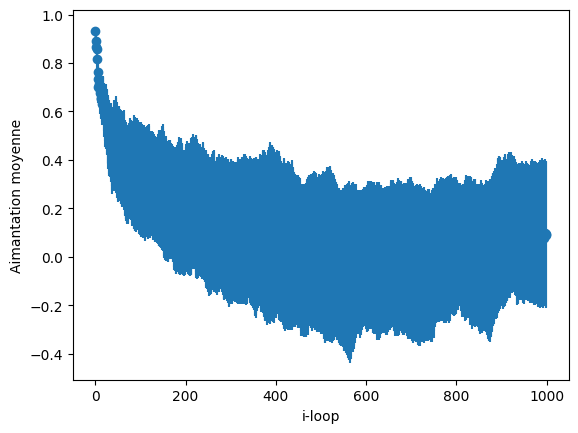

In [4]:
plt.errorbar(np.arange(len(mag)),mag,yerr=errmag,fmt='-o')
xlabel("i-loop")
ylabel("Aimantation moyenne")

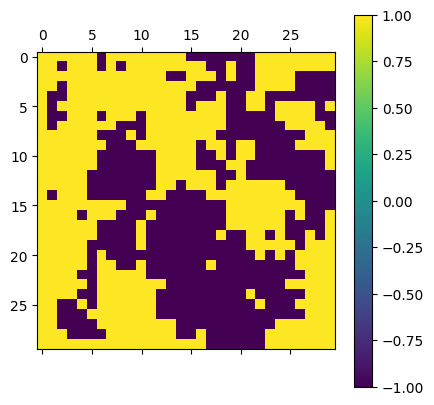

In [5]:
plt.matshow(couche(spin,10));colorbar();


In [6]:
# simulation en fonction de la temperature
def simul(carry,T):
  nloops,key = carry
  key,subkey = jax.random.split(key)
  spin_dtype = key.dtype
  probas = temperature(T)
  spin = jnp.zeros((N,N),dtype=spin_dtype)
  spin = boucle(subkey,nloops,spin,probas)
  carry = (nloops,key)
  return carry, aimant_stat(spin)

In [7]:
Temperature = jnp.linspace(5.0, 0.1, 99) # liste des temperatures

In [8]:
# 99 temp, 1000 loops 30x30 => 2min CPU
init = (1000,jax.random.PRNGKey(42))
_,aimants = jax.lax.scan(simul,init,Temperature)

In [9]:
# theory
Tc = 2/jnp.log(1+jnp.sqrt(2))
def M(t):
  return jax.lax.select(t<Tc,jnp.power((1.0-1.0/jnp.power(jnp.sinh(2.0/t),4)),1/8.0),0.)
vM = jax.vmap(M)

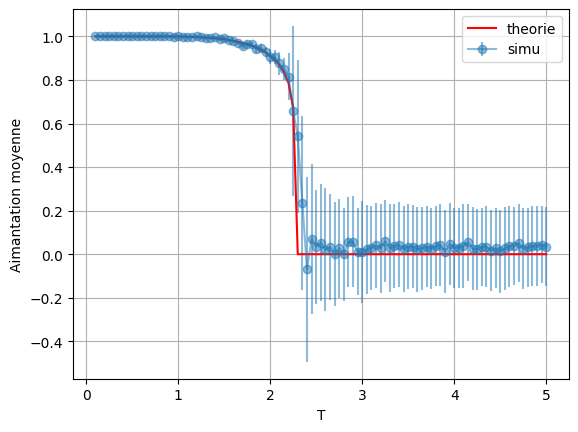

In [11]:
plt.errorbar(Temperature,aimants[0],yerr=aimants[1],fmt='-o',alpha=0.5,label="simu")
plt.plot(Temperature,vM(Temperature),color="r",label="theorie")
grid()
xlabel("T")
ylabel("Aimantation moyenne")
legend();